The goal here is to translate numbers written out in letters into actual numbers.

In [2]:
%matplotlib inline 
%matplotlib nbagg
import tensorflow as tf
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from data_generator import get_batch, print_valid_characters
from tensorflow.python.framework.ops import reset_default_graph

import tf_utils

In [3]:
batch_size = 3
inputs, inputs_seqlen, targets_in, targets_out, targets_seqlen, targets_mask, \
text_inputs, text_targets_in, text_targets_out = \
    get_batch(batch_size=batch_size, max_digits=2, min_digits=1)

print("input types:", inputs.dtype, inputs_seqlen.dtype, targets_in.dtype, targets_out.dtype, targets_seqlen.dtype)
print (print_valid_characters())
print ("Stop/start character = #")

for i in range(batch_size):
    print ("\nSAMPLE",i)
    print ("TEXT INPUTS:\t\t\t", text_inputs[i])
    print ("TEXT TARGETS INPUT:\t\t", text_targets_in[i])
    print ("TEXT TARGETS OUTPUT:\t\t", text_targets_out[i])
    print ("ENCODED INPUTS:\t\t\t", inputs[i])
    print ("INPUTS SEQUENCE LENGTH:\t\t", inputs_seqlen[i])
    print ("ENCODED TARGETS INPUT:\t\t", targets_in[i])
    print ("ENCODED TARGETS OUTPUT:\t\t", targets_out[i])
    print ("TARGETS SEQUENCE LENGTH:\t", targets_seqlen[i])
    print ("TARGETS MASK:\t\t\t", targets_mask[i])

input types: int32 int32 int32 int32 int32
Number of valid characters: 27
'0'=0,	'1'=1,	'2'=2,	'3'=3,	'4'=4,	'5'=5,	'6'=6,	'7'=7,	'8'=8,	'9'=9,	'#'=10,	'r'=11,	'f'=12,	't'=13,	'g'=14,	'w'=15,	'u'=16,	'z'=17,	'o'=18,	'x'=19,	'h'=20,	'n'=21,	'v'=22,	'e'=23,	'i'=24,	's'=25,	' '=26,	
None
Stop/start character = #

SAMPLE 0
TEXT INPUTS:			 three
TEXT TARGETS INPUT:		 #3
TEXT TARGETS OUTPUT:		 3#
ENCODED INPUTS:			 [13 20 11 23 23  0  0  0  0  0  0]
INPUTS SEQUENCE LENGTH:		 5
ENCODED TARGETS INPUT:		 [10  3  0]
ENCODED TARGETS OUTPUT:		 [ 3 10  0]
TARGETS SEQUENCE LENGTH:	 2
TARGETS MASK:			 [ 1.  1.  0.]

SAMPLE 1
TEXT INPUTS:			 seven seven
TEXT TARGETS INPUT:		 #77
TEXT TARGETS OUTPUT:		 77#
ENCODED INPUTS:			 [25 23 22 23 21 26 25 23 22 23 21]
INPUTS SEQUENCE LENGTH:		 11
ENCODED TARGETS INPUT:		 [10  7  7]
ENCODED TARGETS OUTPUT:		 [ 7  7 10]
TARGETS SEQUENCE LENGTH:	 3
TARGETS MASK:			 [ 1.  1.  1.]

SAMPLE 2
TEXT INPUTS:			 eight eight
TEXT TARGETS INPUT:		 #88
TEXT TARGETS OUTPUT:		

In [4]:
# resetting the graph
reset_default_graph()

# Setting up hyperparameters and general configs
MAX_DIGITS = 5
MIN_DIGITS = 5
NUM_INPUTS = 27
NUM_OUTPUTS = 11 #(0-9 + '#')

BATCH_SIZE = 100
# try various learning rates 1e-2 to 1e-5
LEARNING_RATE = 0.005
X_EMBEDDINGS = 8
t_EMBEDDINGS = 8
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10

In [5]:
# Setting up placeholders, these are the tensors that we "feed" to our network
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')

In [6]:
# Building the model

# first we build the embeddings to make our characters into dense, trainable vectors
X_embeddings = tf.get_variable('X_embeddings', [NUM_INPUTS, X_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))
t_embeddings = tf.get_variable('t_embeddings', [NUM_OUTPUTS, t_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))

# setting up weights for computing the final output
W_out = tf.get_variable('W_out', [NUM_UNITS_DEC, NUM_OUTPUTS])
b_out = tf.get_variable('b_out', [NUM_OUTPUTS])

X_embedded = tf.gather(X_embeddings, Xs, name='embed_X')
t_embedded = tf.gather(t_embeddings, ts_in, name='embed_t')

In [7]:
# forward encoding
enc_cell = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)#python.ops.rnn_cell.GRUCell
_, enc_state = tf.nn.dynamic_rnn(cell=enc_cell, inputs=X_embedded,
                                 sequence_length=X_len, dtype=tf.float32)
# use below incase TF's makes issues
#enc_state, _ = tf_utils.encoder(X_embedded, X_len, 'encoder', NUM_UNITS_ENC)
#
#enc_state = tf.concat(1, [enc_state, enc_state])

In [8]:
# decoding
# note that we are using a wrapper for decoding here, this wrapper is hardcoded to only use GRU
# check out tf_utils to see how you make your own decoder
dec_out, valid_dec_out = tf_utils.decoder(enc_state, t_embedded, t_len, 
                                          NUM_UNITS_DEC, t_embeddings,
                                          W_out, b_out)

In [9]:
# reshaping to have [batch_size*seqlen, num_units]
out_tensor = tf.reshape(dec_out, [-1, NUM_UNITS_DEC])
valid_out_tensor = tf.reshape(valid_dec_out, [-1, NUM_UNITS_DEC])
# computing output
out_tensor = tf.matmul(out_tensor, W_out) + b_out
valid_out_tensor = tf.matmul(valid_out_tensor, W_out) + b_out
# reshaping back to sequence
b_size = tf.shape(X_len)[0] # use a variable we know has batch_size in [0]
seq_len = tf.shape(t_embedded)[1] # variable we know has sequence length in [1]
num_out = tf.constant(NUM_OUTPUTS) # casting NUM_OUTPUTS to a tensor variable
out_shape = tf.concat(0, [tf.expand_dims(b_size, 0),
                          tf.expand_dims(seq_len, 0),
                          tf.expand_dims(num_out, 0)])
out_tensor = tf.reshape(out_tensor, out_shape)
valid_out_tensor = tf.reshape(valid_out_tensor, out_shape)
# handling shape loss
#out_tensor.set_shape([None, None, NUM_OUTPUTS])
y = out_tensor
y_valid = valid_out_tensor

In [11]:
# print all the variable names and shapes
for var in tf.all_variables():
    s = var.name + " "*(40-len(var.name))
    print (s, var.value().get_shape())

X_embeddings:0                           (27, 8)
t_embeddings:0                           (11, 8)
W_out:0                                  (10, 11)
b_out:0                                  (11,)
RNN/GRUCell/Gates/Linear/Matrix:0        (18, 20)
RNN/GRUCell/Gates/Linear/Bias:0          (20,)
RNN/GRUCell/Candidate/Linear/Matrix:0    (18, 10)
RNN/GRUCell/Candidate/Linear/Bias:0      (10,)
decoder/W_z_x:0                          (8, 10)
decoder/W_z_h:0                          (10, 10)
decoder/b_z:0                            (10,)
decoder/W_r_x:0                          (8, 10)
decoder/W_r_h:0                          (10, 10)
decoder/b_r:0                            (10,)
decoder/W_c_x:0                          (8, 10)
decoder/W_c_h:0                          (10, 10)
decoder/b_h:0                            (10,)


In [12]:
def loss_and_acc(preds):
    # sequence_loss_tensor is a modification of TensorFlow's own sequence_to_sequence_loss
    # TensorFlow's seq2seq loss works with a 2D list instead of a 3D tensors
    loss = tf_utils.sequence_loss_tensor(preds, ts_out, t_mask, NUM_OUTPUTS) # notice that we use ts_out here!
    # if you want regularization
    #reg_scale = 0.00001
    #regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    #params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    #reg_term = sum([regularize(param) for param in params])
    #loss += reg_term
    # calculate accuracy
    argmax = tf.to_int32(tf.argmax(preds, 2))
    correct = tf.to_float(tf.equal(argmax, ts_out)) * t_mask
    accuracy = tf.reduce_sum(correct) / tf.reduce_sum(t_mask)
    return loss, accuracy, argmax

loss, accuracy, predictions = loss_and_acc(y)
loss_valid, accuracy_valid, predictions_valid = loss_and_acc(y_valid)

# use lobal step to keep track of our iterations
global_step = tf.Variable(0, name='global_step', trainable=False)
# pick optimizer, try momentum or adadelta
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
# extract gradients for each variable
grads_and_vars = optimizer.compute_gradients(loss)
# add below for clipping by norm
#gradients, variables = zip(*grads_and_vars)  # unzip list of tuples
#clipped_gradients, global_norm = (
#    tf.clip_by_global_norm(gradients, self.clip_norm) )
#grads_and_vars = zip(clipped_gradients, variables)
# apply gradients and make trainable function
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

In [13]:
# print all the variable names and shapes
# notice that we now have the optimizer Adam as well!
for var in tf.all_variables():
    s = var.name + " "*(40-len(var.name))
    print (s, var.value().get_shape())

X_embeddings:0                           (27, 8)
t_embeddings:0                           (11, 8)
W_out:0                                  (10, 11)
b_out:0                                  (11,)
RNN/GRUCell/Gates/Linear/Matrix:0        (18, 20)
RNN/GRUCell/Gates/Linear/Bias:0          (20,)
RNN/GRUCell/Candidate/Linear/Matrix:0    (18, 10)
RNN/GRUCell/Candidate/Linear/Bias:0      (10,)
decoder/W_z_x:0                          (8, 10)
decoder/W_z_h:0                          (10, 10)
decoder/b_z:0                            (10,)
decoder/W_r_x:0                          (8, 10)
decoder/W_r_h:0                          (10, 10)
decoder/b_r:0                            (10,)
decoder/W_c_x:0                          (8, 10)
decoder/W_c_h:0                          (10, 10)
decoder/b_h:0                            (10,)
global_step:0                            ()
beta1_power:0                            ()
beta2_power:0                            ()
X_embeddings/Adam:0                      

In [14]:
# as always, test the forward pass and initialize the tf.Session!
# here is some dummy data
batch_size=3
inputs, inputs_seqlen, targets_in, targets_out, targets_seqlen, targets_mask, \
text_inputs, text_targets_in, text_targets_out = \
    get_batch(batch_size=batch_size, max_digits=7, min_digits=2)

for i in range(batch_size):
    print ("\nSAMPLE",i)
    print ("TEXT INPUTS:\t\t\t", text_inputs[i])
    print ("TEXT TARGETS INPUT:\t\t", text_targets_in[i])

# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
# test train part
sess.run(tf.initialize_all_variables())
feed_dict = {Xs: inputs, X_len: inputs_seqlen, ts_in: targets_in,
             ts_out: targets_out, t_len: targets_seqlen}
fetches = [y]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print ("y", res[0].shape)

# test validation part
fetches = [y_valid]
res = sess.run(fetches=fetches, feed_dict=feed_dict)
print ("y_valid", res[0].shape)


SAMPLE 0
TEXT INPUTS:			 nine seven
TEXT TARGETS INPUT:		 #97

SAMPLE 1
TEXT INPUTS:			 five three two zero six
TEXT TARGETS INPUT:		 #53206

SAMPLE 2
TEXT INPUTS:			 nine two seven six
TEXT TARGETS INPUT:		 #9276
y (3, 6, 11)
y_valid (3, 6, 11)


In [15]:
#Generate some validation data
X_val, X_len_val, t_in_val, t_out_val, t_len_val, t_mask_val, \
text_inputs_val, text_targets_in_val, text_targets_out_val = \
    get_batch(batch_size=5000, max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
print ("X_val", X_val.shape)
print ("t_out_val", t_out_val.shape)

X_val (5000, 29)
t_out_val (5000, 6)


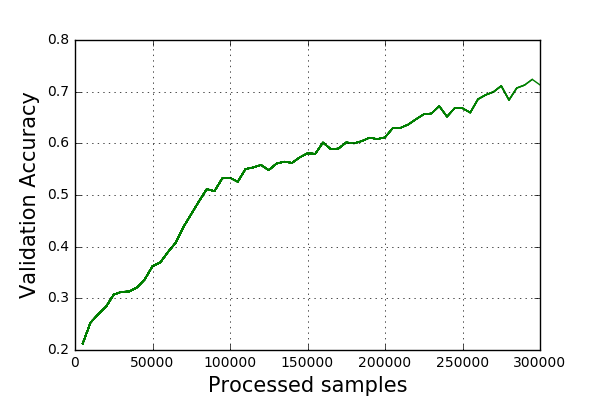

In [16]:
# setting up running parameters
val_interval = 5000
samples_to_process = 3e5
samples_processed = 0
samples_val = []
costs, accs_val = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        # load data
        X_tr, X_len_tr, t_in_tr, t_out_tr, t_len_tr, t_mask_tr, \
        text_inputs_tr, text_targets_in_tr, text_targets_out_tr = \
            get_batch(batch_size=BATCH_SIZE,max_digits=MAX_DIGITS,min_digits=MIN_DIGITS)
        # make fetches
        fetches_tr = [train_op, loss, accuracy]
        # set up feed dict
        feed_dict_tr = {Xs: X_tr, X_len: X_len_tr, ts_in: t_in_tr,
             ts_out: t_out_tr, t_len: t_len_tr, t_mask: t_mask_tr}
        # run the model
        res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
        _, batch_cost, batch_acc = res
        costs += [batch_cost]
        samples_processed += BATCH_SIZE
        #if samples_processed % 1000 == 0: print batch_cost, batch_acc
        #validation data
        if samples_processed % val_interval == 0:
            #print "validating"
            fetches_val = [accuracy_valid, y_valid]
            feed_dict_val = {Xs: X_val, X_len: X_len_val, ts_in: t_in_val,
             ts_out: t_out_val, t_len: t_len_val, t_mask: t_mask_val}
            res = tuple(sess.run(fetches=fetches_val, feed_dict=feed_dict_val))
            acc_val, output_val = res
            samples_val += [samples_processed]
            accs_val += [acc_val]
            plt.plot(samples_val, accs_val, 'g-')
            plt.ylabel('Validation Accuracy', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            plt.savefig("out.png")
            display.display(display.Image(filename="out.png"))
            display.clear_output(wait=True)
except KeyboardInterrupt:
    pass

<IPython.core.display.Javascript object>


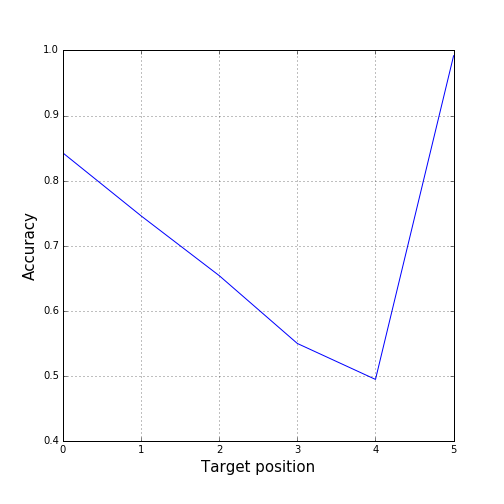

In [17]:
#plot of validation accuracy for each target position
plt.figure(figsize=(7,7))
plt.plot(np.mean(np.argmax(output_val,axis=2)==t_out_val,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()
#why do the plot look like this?